# Imports + General

In [ ]:
# Install unrar
!apt-get install -y unrar

In [ ]:
# Define paths
# rar_file_path_test = '/kaggle/input/CASIA-HWDB/test.rar'  # Path to test RAR in /input
# rar_file_path_train = '/kaggle/input/CASIA-HWDB/train.rar'  # Path to train RAR in /input
# rar_file_path_model_stuff = '/kaggle/input/CASIA-HWDB/model_CASIA_HWDB_stuff.rar'  # Path to model stuff RAR in /input
# extraction_path_test = '/kaggle/working/test'  # Writable path test in /working
# extraction_path_train = '/kaggle/working/train'  # Writable path train in /working
# extraction_path_model_stuff = '/kaggle/working/model_CASIA_HWDB_stuff'  # Writable path model stuff in /working

# Unpack RAR files
# !unrar x {rar_file_path_test} {extraction_path_test}
# !unrar x {rar_file_path_train} {extraction_path_train}
# !unrar x {rar_file_path_model_stuff} {extraction_path_model_stuff}

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
import torch

import torch.nn as nn

import torch.nn.functional as F



import numpy as np

import pandas as pd

import random

import os



from tqdm import tqdm



import torchvision

import torchvision.models as models

from torchvision import transforms, datasets

import torch.utils.data as data

import torchvision.datasets

from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.model_selection import train_test_split

from torchvision.models.resnet import conv3x3, _resnet, ResNet18_Weights

import matplotlib.pyplot as plt

from PIL import ImageOps, Image



random.seed(0)

np.random.seed(0)

torch.manual_seed(0)

torch.cuda.manual_seed(0)

torch.backends.cudnn.deterministic = True

# device = 'cpu' 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



# Paths to data

kkanji_150_path = "/kaggle/input/kkanji/kkanji2_150/kkanji2_150"

kkanji_200_path = "/kaggle/input/kkanji/kkanji2_200/kkanji2_200"

kkanji_300_path = "/kaggle/input/kkanji/kkanji2_300/kkanji2_300"

In [3]:
print(os.cpu_count()) 

4


In [4]:
test_last_epoch = np.load("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff/last_epoch.npy")
print(test_last_epoch)

11


In [ ]:
# Define the path for the new directory
directory_path = '/kaggle/working/model_CASIA_HWDB_stuff'

# Create the directory
os.makedirs(directory_path, exist_ok=True)
print(f"Directory created at: {directory_path}")

In [ ]:
dir_pathes = ['/kaggle/working/model_augmented_150_stuff', '/kaggle/working/model_augmented_200_stuff', '/kaggle/working/model_augmented_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_all_150_stuff', '/kaggle/working/model_pretrained_unfreeze_all_200_stuff', '/kaggle/working/model_pretrained_unfreeze_all_300_stuff'
              , '/kaggle/working/model_pretrained_unfreeze_last_150_stuff', '/kaggle/working/model_pretrained_unfreeze_last_200_stuff', '/kaggle/working/model_pretrained_unfreeze_last_300_stuff']

for dir_path in dir_pathes:
    # Create the directory
    os.makedirs(dir_path, exist_ok=True)
    print(f"Directory created at: {dir_path}")

# PreactBasicBlock

In [5]:
class PreactBasicBlock(nn.Module):

    expansion = 1



    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,

                 base_width=64, dilation=1, norm_layer=None):

        super(PreactBasicBlock, self).__init__()



        if norm_layer is None:

            norm_layer = nn.BatchNorm2d



        if groups != 1 or base_width != 64:

            raise ValueError('BasicBlock only supports groups=1 and base_width=64')



        if dilation > 1:

            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")



        # Both self.conv1 and self.downsample layers downsample the input when stride != 1



        self.bn1 = nn.BatchNorm2d(inplanes)

        self.relu1 = nn.ReLU(inplace=True)

        self.conv1 = conv3x3(inplanes, planes, stride)



        self.bn2 = nn.BatchNorm2d(planes)

        self.relu2 = nn.ReLU(inplace=True)

        self.conv2 = conv3x3(planes, planes)

        

        self.downsample = downsample

        self.stride = stride



    def forward(self, x):

        identity = x



        out = self.bn1(x)

        out = self.relu1(out)

        out = self.conv1(out)



        out = self.bn2(out)

        out = self.relu2(out)

        out = self.conv2(out)



        if self.downsample is not None:

            identity = self.downsample(x)



        out += identity



        return out

    

    # Check what is model params and conv3x3. Also normlayer is not used.

# Cycle func

In [ ]:
def are_weigths_unequal(old_weigths, new_weigths):

    return bool(len([1 for w1, w2 in zip(old_weigths, new_weigths) if not torch.all(w1.eq(w2))]))



def cycle(model, loader, criterion, train=False, optimizer=None, freeze_base=False):

    overall_loss = []

    overall_accuracy = []

    dataloader_iterator = iter(loader)



    if train:

        model.train()

    else:

        model.eval()

    if freeze_base:

        for param in model.parameters():

            param.requires_grad = False



        for param in model.fc.parameters():

            param.requires_grad = True



    model_weigths = list(model.state_dict().values())



    for batch_id in tqdm(range(len(loader))):   

        try:

            X_batch, y_batch = next(dataloader_iterator)

        except:

            dataloader_iterator = iter(loader)

            X_batch, y_batch = next(dataloader_iterator)



        # if batch_id == 2:

        #     if train:

        #         assert are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Model is not training"

                

        #     else:

        #         assert not are_weigths_unequal(model_weigths, list(model.state_dict().values())), "Weigths are chaning while validating"



        #     del model_weigths

    

        X_batch = X_batch.to(device)

        y_batch = y_batch.to(device)



        if train:

            optimizer.zero_grad()

            preds = model(X_batch)



            # print("Preds require grad: ", preds.requires_grad)



            loss_value = criterion(preds, y_batch)



            # print("Loss value require grad: ", loss_value.requires_grad)

            if batch_id % 100 == 0:
                print("Batch is processing:", batch_id)
            loss_value.backward()



            # Check weights

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (before step): ", new_model_weights[0].requires_grad)



            # for param in model.parameters():

            #     print(param.grad.data.sum())

    

            optimizer.step()



            # for param in model.parameters():

            #     print(param.grad.data.sum())



            # Check weights again after optimizer step

            # new_model_weights = list(model.state_dict().values())

            # print("Model weights require grad (after step): ", new_model_weights[0].requires_grad)



        else:

            with torch.no_grad():

                preds = model(X_batch)

                loss_value = criterion(preds, y_batch).mean()



        overall_loss.append(loss_value.mean())



        accuracy = (preds.argmax(dim=1) == y_batch).float().mean().data.cpu()

        overall_accuracy.append(accuracy)



    mean_loss = sum(overall_loss) / len(loader)

    mean_accuracy = sum(overall_accuracy) / len(loader)

    

    return mean_loss.item(), mean_accuracy.item()

In [ ]:
w1 = [torch.tensor([1, 2, 3]), torch.tensor([4, 5, 6])]

w2 = [torch.tensor([1, 2, 3]), torch.tensor([4, 6, 6])]

assert are_weigths_unequal(w1, w2), "Weigths are equal"

# Dataloaders

In [ ]:
# Dataset initialization



def get_dataloaders(batch_size: int = 16, classamount: int = 150):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Grayscale(num_output_channels=3),

                transforms.Resize(64),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    if classamount == 150:

        # Load dataset 150

        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=my_transform)



    elif classamount == 200:

        # Load dataset 200

        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=my_transform)



    elif classamount == 300:

        # Load dataset 300

        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=my_transform)



    # Split dataset into training and testing sets

    train_indices, test_indices = train_test_split(

        list(range(len(full_dataset))),

        test_size=0.3,

        stratify=[label for _, label in full_dataset.samples]

    )



    train_dataset = data.Subset(full_dataset, train_indices)

    test_dataset = data.Subset(full_dataset, test_indices)



    # Calculate class weights for the training set

    class_counts = [0] * len(full_dataset.classes)

    for idx in train_indices:

        _, label = full_dataset.samples[idx]

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



    return trainloader, testloader, full_dataset


# Dataloaders CASIA-HWDB

In [7]:
# Dataset CASIA-HWDB initialization



def invert_image(image):

    if isinstance(image, Image.Image):

        return ImageOps.invert(image)

    else:

        raise TypeError("Input should be a PIL Image")



def get_dataloaders_CASIA_HWDB(batch_size: int = 4096):



    # Define transformations

    my_transform = transforms.Compose([

                transforms.Resize(64),  # Resize the smaller edge to 64 while preserving aspect ratio

                transforms.CenterCrop((64, 64)),  # Center crop to 64x64

                transforms.Lambda(invert_image), # invert colors

                transforms.Grayscale(num_output_channels=3),

                transforms.ToTensor(),

                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)  # Normalize to (-1, 1)

            ])



    # Load dataset

    train_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/train/train", transform=my_transform)

    test_dataset = datasets.ImageFolder(root="/kaggle/input/casia-hwdb/test/test", transform=my_transform)



    # Calculate class weights for the training set

    class_counts = [0] * len(train_dataset.classes)

    for _, label in train_dataset.samples:

        class_counts[label] += 1



    class_weights = [1.0 / count for count in class_counts]

    sample_weights = [class_weights[label] for _, label in train_dataset.samples]



    # Create a WeightedRandomSampler for the training set

    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)



    # Create DataLoaders

    trainloader = data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)

    testloader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)



    return trainloader, testloader, train_dataset


# Dataloaders augmented

In [ ]:
def get_dataloaders_augmented(batch_size: int = 16, classamount: int = 150):
    # Define transformations for training and testing
    train_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.RandomResizedCrop(64, scale=(0.95, 1.05)),
        transforms.RandomAffine(degrees=0, shear=0.05),
        transforms.Resize(64),  # Ensure the image is 64x64
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    test_transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize each channel to (-1, 1)
    ])

    if classamount == 150:
        # Load dataset 150
        full_dataset = datasets.ImageFolder(root=kkanji_150_path, transform=None)
    elif classamount == 200:
        # Load dataset 200
        full_dataset = datasets.ImageFolder(root=kkanji_200_path, transform=None)
    elif classamount == 300:
        # Load dataset 300
        full_dataset = datasets.ImageFolder(root=kkanji_300_path, transform=None)

    # Split dataset into training and testing sets
    train_indices, test_indices = train_test_split(
        list(range(len(full_dataset))),
        test_size=0.3,
        stratify=[label for _, label in full_dataset.samples]
    )

    train_dataset = Subset(full_dataset, train_indices)
    test_dataset = Subset(full_dataset, test_indices)

    # Apply transformations
    train_dataset.dataset.transform = train_transform
    test_dataset.dataset.transform = test_transform

    # Calculate class weights for the training set
    class_counts = [0] * len(full_dataset.classes)
    for idx in train_indices:
        _, label = full_dataset.samples[idx]
        class_counts[label] += 1

    class_weights = [1.0 / count for count in class_counts]
    sample_weights = [class_weights[full_dataset.samples[idx][1]] for idx in train_indices]

    # Create a WeightedRandomSampler for the training set
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    trainloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=4)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return trainloader, testloader, full_dataset

# Testing models

In [ ]:
# Testing loop

def testing_model(class_amount: int = 150, model_suff_path: str = None):



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, False) # 'resnet18'

    model.fc = nn.Linear(model.fc.in_features, class_amount)



    if model_suff_path is not None:

        if os.path.exists(f"{model_suff_path}/model.pth"):

            model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))



    else:

        if os.path.exists(f"model_{class_amount}_stuff/model.pth"):

            model.load_state_dict(torch.load(f"model_{class_amount}_stuff/model.pth"))



    criterion = nn.CrossEntropyLoss()


    # For CASIA-HWDB
    # trainloader, testloader, original_dataset = get_dataloaders_CASIA_HWDB(batch_size=4096)

    # For kkanji
    trainloader, testloader, original_dataset = get_dataloaders(batch_size=4096, classamount=class_amount)

    model = model.to(device)
    
    test_loss, test_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion)



    print('Test: loss', test_loss, 'accuracy', test_accuracy)



    #Accuracy for each class

    class_correct = list(0. for i in range(class_amount))



    class_total = list(0. for i in range(class_amount))



    model.eval()



    with torch.no_grad():

        for data in testloader:

            images, labels = data

            images = images.to(device)

            labels = labels.to(device)

            outputs = model(images)

            _, predicted = torch.max(outputs, 1)

            c = (predicted == labels).squeeze()

            for i in range(len(labels)):

                label = labels[i]

                class_correct[label] += c[i].item()

                class_total[label] += 1



    # Print accuracy for each class using class names

    class_correct_dict = {}

    class_total_dict = {}



    for i in range(class_amount):

        class_correct_dict[original_dataset.classes[i]] = class_correct[i] / class_total[i]

        class_total_dict[original_dataset.classes[i]] = class_total[i]



    class_correct_dict = dict(sorted(class_correct_dict.items(), key=lambda item: item[1], reverse=True))



    for key, value in class_correct_dict.items():

        print(key, value, class_total_dict[key])




# Getting stuff for training

In [ ]:
def getting_stuff_for_training(classamount: int = 150, pathes: dict = None, lr: float = 1e-3, scheduler_step_size: int = 10, scheduler_gamma: float = 0.1, pretrained = False):    

    stuff = {}

    last_epoch = 0

    if os.path.exists(pathes["last_epoch"]):

        last_epoch = np.load(pathes["last_epoch"])

    stuff["last_epoch"] = last_epoch



    model = _resnet(PreactBasicBlock, [2, 2, 2, 2], None, progress=False) # 'resnet18'

    if pretrained:
        
        model.fc = nn.Linear(model.fc.in_features, 6764)

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    if classamount == 150:

        model.fc = nn.Linear(model.fc.in_features, 150)



    elif classamount == 200:

        model.fc = nn.Linear(model.fc.in_features, 200)



    elif classamount == 300:

        model.fc = nn.Linear(model.fc.in_features, 300)



    elif classamount == 6764:

        model.fc = nn.Linear(model.fc.in_features, 6764)

    if not pretrained:

        if os.path.exists(pathes["model"]):

            model.load_state_dict(torch.load(pathes["model"]))



    # if weights is not None:

    #     for param in model.parameters():

    #         param.requires_grad = False



    #     for param in model.fc.parameters():

    #         param.requires_grad = True

    model = model.to(device)
    
    stuff["model"] = model

    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # , weight_decay=0.)

    if os.path.exists(pathes["optimizer"]):

        optimizer.load_state_dict(torch.load(pathes["optimizer"]))

    stuff["optimizer"] = optimizer



    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    if os.path.exists(pathes["scheduler"]):

        scheduler.load_state_dict(torch.load(pathes["scheduler"]))

    stuff["scheduler"] = scheduler



    train_loss_history = []

    if os.path.exists(pathes["train_loss_history"]):

        train_loss_history = list(np.load(pathes["train_loss_history"]))

    stuff["train_loss_history"] = train_loss_history



    train_accuracy_history = []

    if os.path.exists(pathes["train_accuracy_history"]):

        train_accuracy_history = list(np.load(pathes["train_accuracy_history"]))

    stuff["train_accuracy_history"] = train_accuracy_history



    val_loss_history = []

    if os.path.exists(pathes["val_loss_history"]):

        val_loss_history = list(np.load(pathes["val_loss_history"]))

    stuff["val_loss_history"] = val_loss_history



    val_accuracy_history = []

    if os.path.exists(pathes["val_accuracy_history"]):

        val_accuracy_history = list(np.load(pathes["val_accuracy_history"]))

    stuff["val_accuracy_history"] = val_accuracy_history



    max_val_accuracy = 0

    if os.path.exists(pathes["max_val_accuracy"]):

        max_val_accuracy = np.load(pathes["max_val_accuracy"])

    stuff["max_val_accuracy"] = max_val_accuracy



    early_stopping = 5

    if os.path.exists(pathes["early_stopping"]):

        early_stopping = np.load(pathes["early_stopping"])

    stuff["early_stopping"] = early_stopping

    

    return stuff

# Plot func

In [ ]:
def custom_plot(train_data : list = None, val_data : list = None, title: str = None,  ylabel: str = None):

    plt.plot(train_data, label="train")

    plt.plot(val_data, label="validation")

    plt.xlabel('Epochs')

    plt.ylabel(ylabel)

    plt.legend()

    plt.title(title)

    return

# Create pathes vocabulary

In [ ]:
def create_pathes_vocabulary(path : str = None):
    pathes = {"last_epoch": f"{path}/last_epoch.npy", "model": f"{path}/model.pth", "optimizer": f"{path}/optimizer.pth", 
    "scheduler": f"{path}/scheduler.pth", "train_loss_history": f"{path}/train_loss_history.npy", "train_accuracy_history": f"{path}/train_accuracy_history.npy", 
    "val_loss_history": f"{path}/val_loss_history.npy", "val_accuracy_history": f"{path}/val_accuracy_history.npy", 
    "max_val_accuracy": f"{path}/max_val_accuracy.npy", "early_stopping": f"{path}/early_stopping.npy"}

    return pathes
    

# Train loop

In [ ]:
def train_loop(trainloader, testloader, stuff : dict = None, criterion=nn.CrossEntropyLoss(), save_path : str = None, epochs : int = 100, model_name : str = None, freeze_base : bool = False):

    last_epoch = stuff["last_epoch"]

    epochs += last_epoch 



    model = stuff["model"]

    optimizer = stuff["optimizer"]

    scheduler = stuff["scheduler"]



    train_loss_history = stuff["train_loss_history"]

    train_accuracy_history = stuff["train_accuracy_history"]



    val_loss_history = stuff["val_loss_history"]

    val_accuracy_history = stuff["val_accuracy_history"]



    max_val_accuracy = stuff["max_val_accuracy"]

    early_stopping = stuff["early_stopping"]

    for epoch in tqdm(range(last_epoch, epochs)):

        train_loss, train_accuracy = cycle(model, trainloader, criterion, train=True, optimizer=optimizer, freeze_base=freeze_base) #train(model, trainloader, criterion, optimizer, batch_size)

        train_loss_history.append(train_loss)

        train_accuracy_history.append(train_accuracy)



        val_loss, val_accuracy = cycle(model, testloader, criterion) #validate(model, testloader, criterion, batch_size)

        val_loss_history.append(val_loss)

        val_accuracy_history.append(val_accuracy)



        scheduler.step()



        print('Epoch:', epoch+1)

        print('Train: loss', train_loss, 'accuracy', train_accuracy)

        print('Validation: loss', val_loss, 'accuracy', val_accuracy)



        if val_accuracy > max_val_accuracy:

            max_val_accuracy = val_accuracy

            early_stopping = 5



            # Save the model

            torch.save(model.state_dict(), f'{save_path}/model.pth')



            # Save the optimizer

            torch.save(optimizer.state_dict(), f'{save_path}/optimizer.pth')



            # Save the scheduler

            torch.save(scheduler.state_dict(), f'{save_path}/scheduler.pth')



            # Save the loss history

            np.save(f'{save_path}/train_loss_history.npy', train_loss_history)

            np.save(f'{save_path}/val_loss_history.npy', val_loss_history)



            # Save the accuracy history

            np.save(f'{save_path}/train_accuracy_history.npy', train_accuracy_history)

            np.save(f'{save_path}/val_accuracy_history.npy', val_accuracy_history)



            # Save the last epoch

            np.save(f'{save_path}/last_epoch.npy', epoch+1)



            # Save max validation accuracy

            np.save(f'{save_path}/max_val_accuracy.npy', max_val_accuracy)



            # Save early stopping

            np.save(f'{save_path}/early_stopping.npy', early_stopping)



        else:

            early_stopping -= 1



        if early_stopping == 0:

            break

    

    print(f'Best validation accuracy for {model_name}:', max(val_accuracy_history), 'Epoch', val_accuracy_history.index(max(val_accuracy_history))+1)

    return

# 150 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("model_150_stuff")

trainloader, testloader, _ = get_dataloaders(classamount=150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [ ]:
# Train loop

train_loop(trainloader, testloader, stuff=stuff, save_path="model_150_stuff", model_name="150 classes")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=150)

# 200 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("model_200_stuff")

trainloader, testloader, _ = get_dataloaders(classamount=200)

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff=stuff, save_path="model_200_stuff", model_name="200 classes")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=200)

# 300 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("model_300_stuff")

trainloader, testloader, _ = get_dataloaders(classamount=300)

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff=stuff, save_path="model_300_stuff", model_name="300 classes")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300)

# Augmented, 150 classes logic

In [ ]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_150_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_150_stuff", model_name="150 classes augmented")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes augmented", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes augmented", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_augmented_150_stuff")

# Augmented, 200 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_200_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=200)

stuff = getting_stuff_for_training(classamount=200, pathes=pathes)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_200_stuff", model_name="200 classes augmented")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes augmented", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes augmented", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_augmented_200_stuff")

# Augmented, 300 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_augmented_300_stuff")

trainloader, testloader, _ = get_dataloaders_augmented(batch_size=4096, classamount=300)

stuff = getting_stuff_for_training(classamount=300, pathes=pathes)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff=stuff, save_path="/kaggle/working/model_augmented_300_stuff", model_name="300 classes augmented")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes augmented", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes augmented", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_augmented_300_stuff")

# Pretrained CASIA-HWDB unfreeze all, 150 classes logic

In [ ]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

In [ ]:
# Training loop 

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff", model_name="150 classes unfreeze all")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze all", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze all", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_150_stuff")

# Pretrained CASIA-HWDB unfreeze all, 200 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200)

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff", model_name="200 classes unfreeze all")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze all", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze all", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_200_stuff")

# Pretrained CASIA-HWDB unfreeze all, 300 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_all_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300)

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff", model_name="300 classes unfreeze all")

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze all", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze all", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_all_300_stuff")

# Pretrained CASIA-HWDB unfreeze last, 150 classes logic

In [ ]:
# Getting stuff for training 

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_150_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 150)

stuff = getting_stuff_for_training(classamount=150, pathes=pathes, pretrained=True)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff", model_name="150 classes unfreeze last", freeze_base=True)

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 150 classes unfreeze last", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 150 classes unfreeze last", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=150, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_150_stuff")

# Pretrained CASIA-HWDB unfreeze last, 200 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_200_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 200)

stuff = getting_stuff_for_training(classamount=200, pathes=pathes, pretrained=True)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff", model_name="200 classes unfreeze last", freeze_base=True)

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 200 classes unfreeze last", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 200 classes unfreeze last", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=200, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_200_stuff")

# Pretrained CASIA-HWDB unfreeze last, 300 classes logic

In [ ]:
# Getting stuff for training

pathes = create_pathes_vocabulary("/kaggle/input/kkanji/stuff_for_models/model_pretrained_unfreeze_last_300_stuff")

trainloader, testloader, _ = get_dataloaders(batch_size = 4096, classamount = 300)

stuff = getting_stuff_for_training(classamount=300, pathes=pathes, pretrained=True)

In [ ]:
# Training loop

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff", model_name="300 classes unfreeze last", freeze_base=True)

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for 300 classes unfreeze last", "Accuracy")

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for 300 classes unfreeze last", "Loss")

In [ ]:
# Testing model

testing_model(class_amount=300, model_suff_path="/kaggle/working/model_pretrained_unfreeze_last_300_stuff")

# CASIA-HWDB logic

In [ ]:
# Getting stuff for training
pathes = create_pathes_vocabulary("/kaggle/input/casia-hwdb/model_CASIA_HWDB_stuff/model_CASIA_HWDB_stuff")

trainloader, testloader, _ = get_dataloaders_CASIA_HWDB(batch_size=4096)

stuff = getting_stuff_for_training(classamount=6764, pathes=pathes)

/tmp/ipykernel_30/4290371203.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pathes["model"]))
/tmp/ipykernel_30/4290371203.py:69: Futu

In [ ]:
# Training loop 

train_loop(trainloader, testloader, stuff, save_path="/kaggle/working/model_CASIA_HWDB_stuff", model_name="CASIA_HWDB")

  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [08:29<32:26,  3.22s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [16:30<25:17,  3.01s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [24:06<19:26,  2.89s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [31:21<14:04,  2.78s/it]

Batch is processing: 400



 71%|███████   | 500/704 [38:26<09:19,  2.74s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [45:15<04:33,  2.63s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [51:58<00:10,  2.58s/it]

Batch is processing: 700



100%|██████████| 704/704 [52:11<00:00,  4.45s/it]

100%|██████████| 176/176 [18:49<00:00,  6.42s/it]


Epoch: 12
Train: loss 0.024677976965904236 accuracy 0.9938468933105469
Validation: loss 0.3320419192314148 accuracy 0.932234525680542


  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [07:12<26:58,  2.68s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [14:08<22:51,  2.72s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [21:15<18:50,  2.80s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [28:21<13:37,  2.69s/it]

Batch is processing: 400



 71%|███████   | 500/704 [35:16<09:20,  2.75s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [42:14<04:38,  2.68s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [48:56<00:10,  2.60s/it]

Batch is processing: 700



100%|██████████| 704/704 [49:10<00:00,  4.19s/it]

100%|██████████| 176/176 [08:32<00:00,  2.91s/it]


Epoch: 13
Train: loss 0.01859004609286785 accuracy 0.9956491589546204
Validation: loss 0.33840808272361755 accuracy 0.932299017906189


  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [06:35<25:46,  2.56s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [13:01<20:59,  2.50s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [19:17<16:26,  2.44s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [25:17<12:45,  2.52s/it]

Batch is processing: 400



 71%|███████   | 500/704 [31:16<08:27,  2.49s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [37:17<04:13,  2.44s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [43:17<00:09,  2.36s/it]

Batch is processing: 700



100%|██████████| 704/704 [43:29<00:00,  3.71s/it]

100%|██████████| 176/176 [10:43<00:00,  3.65s/it]


Epoch: 14
Train: loss 0.012146293185651302 accuracy 0.9973730444908142
Validation: loss 0.3478907644748688 accuracy 0.9325065612792969


  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [06:32<26:51,  2.67s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [12:28<22:08,  2.64s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [18:28<17:48,  2.64s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [24:27<13:39,  2.70s/it]

Batch is processing: 400



 71%|███████   | 500/704 [30:26<09:14,  2.72s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [36:29<04:58,  2.87s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [42:18<00:10,  2.69s/it]

Batch is processing: 700



100%|██████████| 704/704 [42:31<00:00,  3.62s/it]

  4%|▍         | 4/100 [3:54:00<89:27:07, 3354.45s/it]

Epoch: 15
Train: loss 0.01988203637301922 accuracy 0.9956651329994202
Validation: loss 0.3538207411766052 accuracy 0.9316055774688721



  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [06:03<24:03,  2.39s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [11:53<19:44,  2.35s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [17:30<16:19,  2.43s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [23:05<14:34,  2.88s/it]

Batch is processing: 400



 71%|███████   | 500/704 [28:41<10:34,  3.11s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [34:19<05:33,  3.20s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [39:57<00:13,  3.25s/it]

Batch is processing: 700



100%|██████████| 704/704 [40:04<00:00,  3.42s/it]

  5%|▌         | 5/100 [4:43:20<84:45:46, 3212.07s/it]

Epoch: 16
Train: loss 0.018592318519949913 accuracy 0.9960979223251343
Validation: loss 0.3647560179233551 accuracy 0.9312732219696045



  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [05:45<22:44,  2.26s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [11:13<19:22,  2.31s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [17:00<15:02,  2.23s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [22:30<12:20,  2.44s/it]

Batch is processing: 400



 71%|███████   | 500/704 [28:02<07:36,  2.24s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [33:29<03:53,  2.24s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [38:58<00:08,  2.22s/it]

Batch is processing: 700



100%|██████████| 704/704 [39:09<00:00,  3.34s/it]

  6%|▌         | 6/100 [5:31:56<81:14:25, 3111.33s/it]

Epoch: 17
Train: loss 0.014550569467246532 accuracy 0.9970085620880127
Validation: loss 0.3707795739173889 accuracy 0.9314289093017578



  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [05:47<23:29,  2.33s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [11:12<18:48,  2.24s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [16:30<17:28,  2.59s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [21:51<15:36,  3.08s/it]

Batch is processing: 400



 71%|███████   | 500/704 [27:17<13:07,  3.86s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [32:43<07:05,  4.09s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [38:00<00:16,  4.06s/it]

Batch is processing: 700



100%|██████████| 704/704 [38:03<00:00,  3.24s/it]

  7%|▋         | 7/100 [6:18:37<77:45:12, 3009.81s/it]

Epoch: 18
Train: loss 0.010750296525657177 accuracy 0.9979150891304016
Validation: loss 0.38388562202453613 accuracy 0.9309354424476624



  0%|          | 0/704 [00:00<?, ?it/s]

Batch is processing: 0



 14%|█▍        | 100/704 [05:30<21:44,  2.16s/it]

Batch is processing: 100



 28%|██▊       | 200/704 [10:46<17:52,  2.13s/it]

Batch is processing: 200



 43%|████▎     | 300/704 [16:05<14:41,  2.18s/it]

Batch is processing: 300



 57%|█████▋    | 400/704 [21:22<10:55,  2.16s/it]

Batch is processing: 400



 71%|███████   | 500/704 [26:53<07:42,  2.27s/it]

Batch is processing: 500



 85%|████████▌ | 600/704 [32:22<03:56,  2.27s/it]

Batch is processing: 600



 99%|█████████▉| 700/704 [37:46<00:08,  2.15s/it]

Batch is processing: 700



100%|██████████| 704/704 [37:56<00:00,  3.23s/it]

  7%|▋         | 7/100 [7:05:45<94:16:31, 3649.37s/it]

Epoch: 19
Train: loss 0.008474987931549549 accuracy 0.9983562231063843
Validation: loss 0.39540472626686096 accuracy 0.9308032989501953
Best validation accuracy for CASIA-HWDB: 0.9325065612792969 Epoch 14


Text(0.5, 1.0, 'Accuracy for CASIA-HWDB')

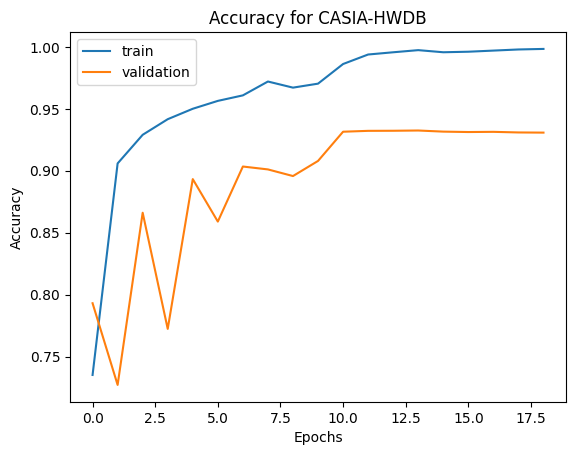

In [ ]:
custom_plot(train_accuracy_history, val_accuracy_history, "Accuracy for CASIA-HWDB", "Accuracy")

Text(0.5, 1.0, 'Loss for CASIA-HWDB')

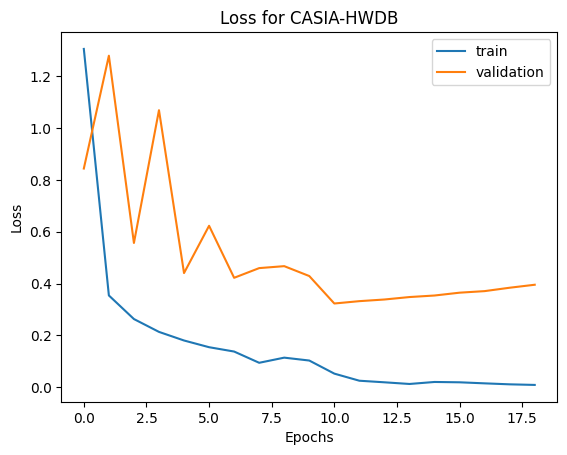

In [ ]:
custom_plot(train_loss_history, val_loss_history, "Loss for CASIA-HWDB", "Loss")

In [23]:
# Testing model

testing_model(class_amount=6764, model_suff_path="/kaggle/working/model_CASIA_HWDB_stuff")

/tmp/ipykernel_30/2314565953.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_suff_path}/model.pth"))
  0%|          | 0/176 [0

Test: loss 0.3478907644748688 accuracy 0.9325065612792969


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b01725d9ab0>Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packag

乾 1.0 144.0
亵 1.0 58.0
仫 1.0 60.0
佧 1.0 60.0
俎 1.0 59.0
俜 1.0 60.0
俪 1.0 60.0
倏 1.0 60.0
傣 1.0 142.0
傧 1.0 59.0
儇 1.0 58.0
兕 1.0 59.0
凹 1.0 142.0
凿 1.0 145.0
剽 1.0 60.0
劁 1.0 60.0
劐 1.0 60.0
劓 1.0 60.0
勰 1.0 60.0
匏 1.0 60.0
卺 1.0 58.0
厝 1.0 60.0
厣 1.0 59.0
咧 1.0 83.0
咫 1.0 59.0
哿 1.0 59.0
唣 1.0 59.0
唳 1.0 60.0
啊 1.0 142.0
啕 1.0 60.0
喃 1.0 60.0
嗫 1.0 60.0
嗲 1.0 60.0
嘤 1.0 60.0
嘭 1.0 59.0
嘶 1.0 143.0
噔 1.0 60.0
噗 1.0 60.0
噤 1.0 60.0
噱 1.0 60.0
圳 1.0 60.0
坩 1.0 59.0
垴 1.0 60.0
堙 1.0 59.0
墁 1.0 59.0
夔 1.0 59.0
奘 1.0 59.0
妤 1.0 59.0
妯 1.0 60.0
姹 1.0 60.0
娉 1.0 60.0
婀 1.0 60.0
媲 1.0 60.0
媾 1.0 60.0
嫔 1.0 59.0
嫦 1.0 59.0
嬗 1.0 59.0
嬷 1.0 58.0
孀 1.0 59.0
孬 1.0 58.0
孱 1.0 60.0
寰 1.0 60.0
屐 1.0 60.0
峤 1.0 60.0
崂 1.0 60.0
崛 1.0 59.0
嵇 1.0 60.0
嵊 1.0 60.0
嵬 1.0 60.0
嶙 1.0 60.0
嶷 1.0 59.0
帼 1.0 60.0
幄 1.0 60.0
幞 1.0 60.0
幡 1.0 60.0
庑 1.0 60.0
廑 1.0 60.0
廨 1.0 60.0
弑 1.0 60.0
彀 1.0 60.0
彘 1.0 59.0
徕 1.0 60.0
恐 1.0 143.0
恸 1.0 60.0
恹 1.0 60.0
悒 1.0 59.0
悖 1.0 60.0
悱 1.0 60.0
惬 1.0 60.0
愆 1.0 60.0
愍 1